# Parameter space analysis 
-----
- Definition of units and parameters:

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, dblquad
from sympy.solvers import solve
from sympy import Symbol, im
from scipy.special import zeta
from scipy.integrate import odeint
import pandas as pd
from tqdm import tqdm

# Useful for ploting, latex output is turned of
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "monospace",
    "font.monospace": 'Computer Modern'})
plt.rcParams.update({'font.size': 15})
plt.rc('text', usetex=False)
plt.rc('font', family='serif')

# UNITS
GeV = pow(10,9) # eV
m = 1/(1.9733*pow(10,-16))*pow(GeV,-1)
kg = 1/1.7827*pow(10,27)*GeV
s = (1/6.5823)*pow(10,25)*pow(GeV,-1)
km = pow(10,3)*m
pc = 3.0857*pow(10,16)*m
Mpc = pow(10,6)*pc
K = 8.621738*pow(10,-5) #eV

# Plank mass
mpl = 1.2209*pow(10,19)*GeV 

# LambaCDM parameters
H0 = 67.4*km/s/Mpc # Hubble parameter
w_r = 2.469*10**(-5) # Amendola pag 15
Om = 0.315 # Omega_matter
h = 67.4/100 # reduced hubble parameter
Or = w_r/(h**2) # Omega_radiation
Ol = 1. - Or - Om # Omega_Lambda

# Hubble parameter evolution
def H(a):
    return H0*np.sqrt(abs(Om*pow(a,-3)+Or*pow(a,-4)+Ol))

- Grid of scale factor:

In [2]:
# Scale factor grid
var_a_len = 1000
a_initial_power = -25
a_final_power = 0
var_a = np.logspace(a_initial_power, a_final_power, base=10, num=var_a_len)

# Computing the age of the universe as a function of the scale factor
def axH(a):
    return 1/(a*H(a))
def t(a):
    quadrature = quad(axH,0,a)
    return quadrature[0]

- Computing cosmological background

In [3]:
# Early universe relations
def trad(T):
    g_star = 109.75
    return 0.301*pow(g_star,-0.5)*mpl/pow(T,2)

def Trad_t(t):
    g_star = 109.75
    return pow(0.301*pow(g_star,-0.5)*mpl/t,0.5)

df = pd.DataFrame([x for x in range(len(var_a))], columns=['ind'])

df['a'] = var_a
df['t'] = [t(a) for a in var_a]
df['T'] = Trad_t(df['t'][0])*df['a'][0]/df['a']
df['H'] = H(df['a'])

- Solving the value of the chemical potential across the evolution of the universe

In [4]:
# Fixed parameters
mf = 0.1 # neutrino bounds
gn = 2 # Neutrino internal degrees of freedom
n0 = 339.5*pow(pow(10,-2)*m,-3) # Current number density of neutrinos
dif_c0 = pow(10,-9)*n0 # current value of neutrino assymetry

def solving_mu(a):
    x = Symbol('x')
    F = gn*pow(Trad_t(t(a)),3)/(6*pow(np.pi,2))*(pow(np.pi,2)*x/Trad_t(t(a)) + pow(x/Trad_t(t(a)),3)) - dif_c0*pow(a,-3)
    if im(solve(F,x)[0])!=0:
        print('OJO, imaginary root')
    return float(solve(F,x)[0])

mus = [solving_mu(x) for x in var_a]
df['mu'] = mus
df.to_csv('cosmo_parameter_analysis.csv')
#df = pd.read_csv('cosmo_parameter_analysis.csv',header=0,index_col=0)

- Defining relevant temperatures and scale factors

In [5]:
T_dec = 1.5*pow(10,6) # neutrino decoupling
T_elepos = 0.8*pow(10,6) # e+e- annihilation
T_chiral = pow(10,11) # chiral symmetry breaking scale

# Locating the value of the scale factor at neutrino decoupling
Tdec = T_dec
df['dif'] = abs(df['T']-Tdec)
nearest_index = df['dif'].idxmin()
a_nudec = df['a'].iloc[nearest_index]
idx_chiral = np.abs(df['T']-T_chiral).idxmin()
print('Scale factor of neutrino decoupling:', a_nudec, 'at T=', Tdec, 'eV')

Scale factor of neutrino decoupling: 5.817880074344935e-11 at T= 1500000.0 eV


- Exploring the space of parameters, comparing the rates of interaction with the Hubble rate

In [6]:
import warnings

df_gMB = df.copy()

# Ignore all warnings for the entire script
warnings.filterwarnings("ignore")

MB_list = np.logspace(0, 15, base=10, num=500)
g_list = np.logspace(-20, 0, base=10, num=500)

Eq_cond = np.ones([len(MB_list),len(g_list)])

B_decay_scale = np.zeros([len(MB_list),len(g_list)])

# First index corresponds to MB index and second g index

for idx1 in tqdm(range(len(MB_list))):
    
    for idx2 in range(len(g_list)):
        
        MB = MB_list[idx1]
        g = g_list[idx2]

        df_gMB['Gamma_B'] = pow(g,2)*MB/(48*np.pi)*(1+2*pow(mf/MB,2))
        
        # If Gamma_B is negative we impose it to be 0 (no physical sense)
        df_gMB['Gamma_B'] = df_gMB['Gamma_B']*(df_gMB['Gamma_B']>0)
        
        # Commoving fermionic charge 
        rho_c = -g*dif_c0

        # Antifermion number density
        df_gMB['n_fbar'] = 3/4*zeta(3)/pow(np.pi,2)*gn*pow(df_gMB['T'],3)

        # Assymetry number density
        df_gMB['n_f-n_fbar'] = dif_c0*pow(df['a'],-3)

        # Fermion number density
        df_gMB['n_f'] = df_gMB['n_f-n_fbar'] + df_gMB['n_fbar']

        # Rate of decays of B particles
        df_gMB['Gamma_B'] = pow(g,2)*MB/(48*np.pi)*(1+2*pow(mf/MB,2))
            # If Gamma_B is negative we impose it to be nan (no physical sense)
        df_gMB['Gamma_B'] = np.array(df_gMB['Gamma_B'])*(df_gMB['Gamma_B']>0)

        # Relative velocity between fermion and antifermion in the CM system
        df_gMB['v_rel'] = 8

        # Rate of f fbar scattering with B as a mediator
        df_gMB['Gamma_ann_long'] = pow(g,4)*pow(df_gMB['T'],2)/pow(MB,4)*df_gMB['n_f']*df_gMB['v_rel']
        df_gMB['Gamma_ann_long'] = df_gMB.Gamma_ann_long.astype(float)
        df_gMB['Gamma_ann_trans'] = pow(g,4)*pow(df_gMB['T'],-2)*df_gMB['n_f']*df_gMB['v_rel']

        T_chiral = 100*pow(10,9) #eV , Chiral symmetry recovery
        nearest_index = (np.abs(df_gMB['T']-T_chiral)).idxmin()
        gamma_transition = (df_gMB['Gamma_ann_long'] + df_gMB['Gamma_ann_trans']).iloc[nearest_index]

        df_gMB['Gamma_ann'] = ((df_gMB['Gamma_ann_long'] + df_gMB['Gamma_ann_trans'])*(df_gMB['T']<T_chiral) + 
                               (df_gMB['Gamma_ann_trans'] + gamma_transition)*(df_gMB['T']>T_chiral))
        
        
        # Checking if B is in equilibrium
        if ((np.sum((df_gMB['Gamma_ann']<df['H'])[idx_chiral:])==0)):
            Eq_cond[idx1,idx2]=0 # 0 means that we cannot neglect Boltzmann
            B_decay_scale[idx1,idx2] = 0
        else:
            # Saving the value of a at which Gamma_B = H 
            if ((np.sum(df_gMB['Gamma_B']>df_gMB['H'])!=0) and 
                (df_gMB['Gamma_B'][0] < df_gMB['H'][0])):
                df['dif'] = np.array(np.abs(df_gMB['H'] - df_gMB['Gamma_B']),dtype=float)
                nearest_index = df['dif'].idxmin()

                
                if df['a'].iloc[nearest_index]>a_nudec:
                    B_decay_scale[idx1,idx2] = 3
                elif df['a'].iloc[nearest_index]<=a_nudec:
                    B_decay_scale[idx1,idx2] = 2
            else:
                B_decay_scale[idx1,idx2] = 4
            if np.sum((df_gMB['Gamma_B']>df_gMB['H'])[:idx_chiral])!=0:
                B_decay_scale[idx1,idx2] = 1
        
        if ((np.sum((df_gMB['Gamma_ann']<df['H'])[idx_chiral:])==0)):
            Eq_cond[idx1,idx2]=0 # 0 means that we cannot neglect Boltzmann
            B_decay_scale[idx1,idx2] = 0

        

        #print(idx1, idx2)
                
                
safe = pd.DataFrame(B_decay_scale)  
#safe.to_csv('B_decay_scale.csv',index=None)

100%|█████████████████████████████████████████| 500/500 [04:01<00:00,  2.07it/s]


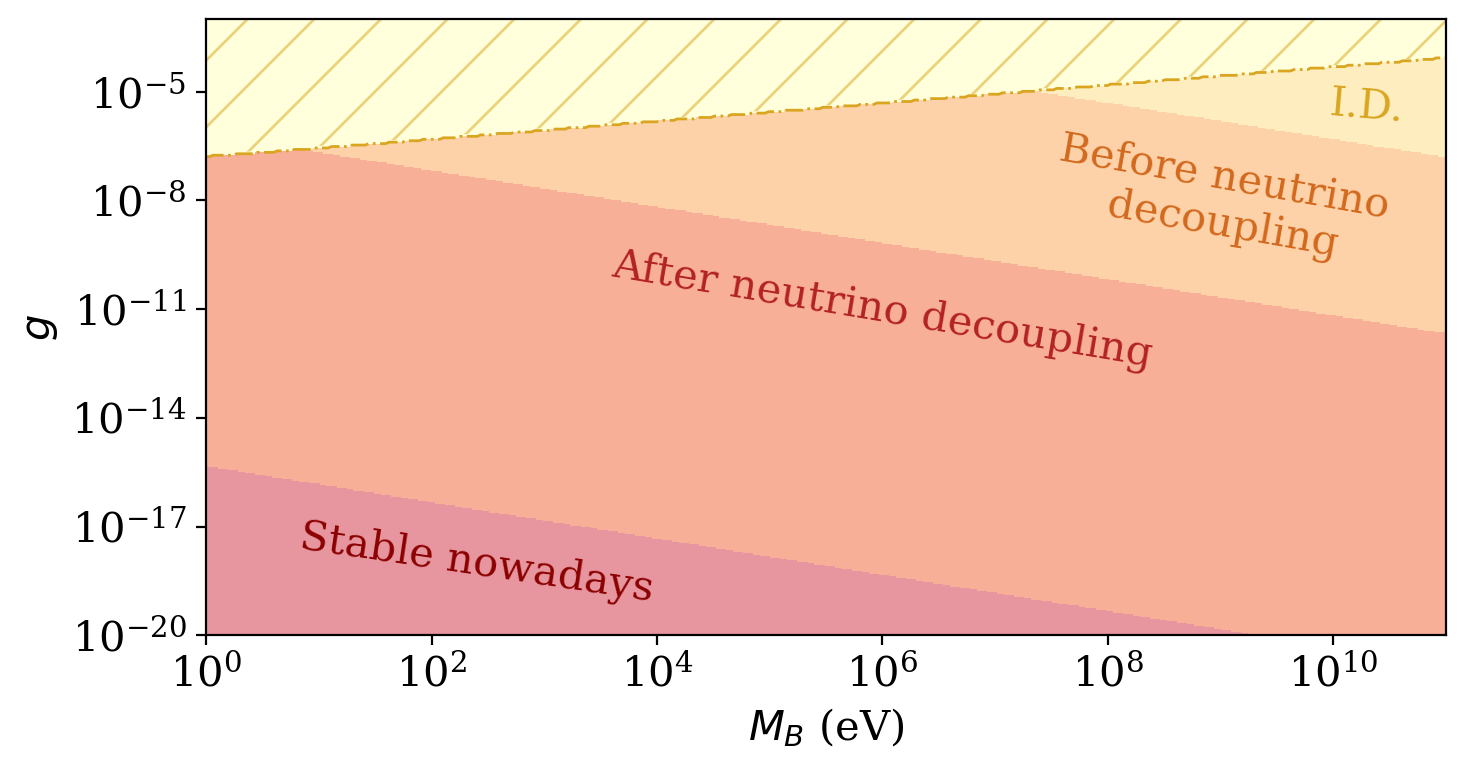

In [7]:
import colormaps as cmaps
from cycler import cycler
from matplotlib.ticker import LogLocator, NullFormatter
from matplotlib.ticker import AutoMinorLocator
import numpy.ma as ma

cmap = cmaps.spectral[:5][::-1]

fig = plt.figure(figsize=(8,4))
ax = plt.gca()

MB_list = np.logspace(0, 15, base=10, num=500)
g_list = np.logspace(-20, 0, base=10, num=500)

im = plt.pcolormesh(MB_list,g_list,np.transpose(B_decay_scale),cmap=cmap,alpha=0.55)
plt.loglog()

rec = plt.Rectangle((10**0, 1.8*10**(-7)), 10**14, 1,           
                    facecolor='none',
                    edgecolor='goldenrod',
                    hatch='/',           
                    linewidth=0, alpha=0.5,
                    zorder=1, angle = 0.0000000000000003)
ax.add_patch(rec)

ax.contour(MB_list,g_list, np.transpose(B_decay_scale)==0,
           levels=[0.5],              # Boundary between 0 and 1
           colors='goldenrod',              # Edge color
           linewidths=1,            # Edge width
           linestyles='-.')

for spine in ax.spines.values():
    spine.set_visible(True)

plt.xlabel('$M_B$ (eV)')
plt.ylabel('$g$')
plt.text(250,10**-18, 'Stable nowadays', color = 'darkred', rotation=-8.5, ha='center', va='center')
plt.text(10**6,10**-11, 'After neutrino decoupling', color = 'firebrick', rotation=-9.5, ha='center', va='center')
plt.text(10**9,10**-8, 'Before neutrino\n decoupling', color = 'chocolate', rotation=-10, ha='center', va='center')
plt.text(2*10**10,0.4*10**-5, 'I.D.', color = 'goldenrod', rotation=-5, ha='center', va='center')
#plt.text(0.5*10**4,10**-5, 'Inconclusive', color = 'chocolate', rotation=6, ha='center', va='center')
plt.ylim(pow(10,-20),pow(10,-3))
plt.xlim(pow(10,0),T_chiral)

fig.savefig('images/decoupling_parameter.png',bbox_inches='tight', dpi=300)
plt.show()

_______